**Judul Tugas Besar:** Deteksi Kolam Renang dalam Manajemen Bencana Kebakaran Hutan \
**Kelas:** IF-42-GAB \
**Kelompok:** 3 \
**Anggota Kelompok**: \

1.   Muhamad Farell Ambiar (1301184262) 
2.   Mohammad Daffa Haris (1301180355)
3.   Ryan Adeputra Sutopo (1301180297)



# Import Library

In [ ]:
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm

import glob
import os
import cv2
import matplotlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import GroupKFold

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

import albumentations as albu

# Import Dataset

In [ ]:
!git clone https://github.com/alleFarell/Datasets-ML.git

Cloning into 'Datasets-ML'...
remote: Enumerating objects: 3676, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 3676 (delta 9), reused 43 (delta 9), pack-reused 3633
Receiving objects: 100% (3676/3676), 884.16 MiB | 36.82 MiB/s, done.
Resolving deltas: 100% (1230/1230), done.
Checking out files: 100% (3653/3653), done.


## Get Train Images and Labels Path

In [ ]:
LABELS_PATH = 'Datasets-ML/Aerial Dataset Swimming Pool/CANNES_TILES_512x512_labels/CANNES_TILES_512x512_labels/'
TRAIN_DIR = 'Datasets-ML/Aerial Dataset Swimming Pool/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG/'

## Convert XML file to Dataframe

In [ ]:
def xml_to_dataframe(path):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(float(bbx.find('xmin').text))
            ymin = int(float(bbx.find('ymin').text))
            xmax = int(float(bbx.find('xmax').text))
            ymax = int(float(bbx.find('ymax').text))
            label = member.find('name').text
            
            value = (os.path.splitext(root.find('filename').text)[0] + '.png', 
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['image_id', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
df = xml_to_dataframe(LABELS_PATH)

100%|██████████| 1224/1224 [00:00<00:00, 10668.58it/s]


## Create Folds for Train and Validation Data

In [ ]:
df['fold'] = -1
group_kfold  = GroupKFold(n_splits = 3)
for fold, (train_index, val_index) in enumerate(group_kfold.split(df, groups=df.image_id.tolist())):
    df.loc[val_index, 'fold'] = fold

df.head(10)

image_id  width  height class  ...  ymin  xmax  ymax  fold
0   CANNES_TILES_512x512.368.png    512     512  pool  ...   123   414   185     1
1   CANNES_TILES_512x512.110.png    512     512  pool  ...   161    27   212     0
2   CANNES_TILES_512x512.110.png    512     512  pool  ...    93   334   158     0
3    CANNES_TILES_512x512.47.png    512     512  pool  ...     1   190    50     1
4    CANNES_TILES_512x512.47.png    512     512  pool  ...   168   459   217     1
5    CANNES_TILES_512x512.47.png    512     512  pool  ...     1   512    36     1
6    CANNES_TILES_512x512.47.png    512     512  pool  ...   380   512   405     1
7  CANNES_TILES_512x512.2134.png    512     512  pool  ...   399   443   435     0
8  CANNES_TILES_512x512.2134.png    512     512  pool  ...     7   207    62     0
9   CANNES_TILES_512x512.560.png    512     512  pool  ...   420   188   480     0

[10 rows x 9 columns]

In [ ]:
df.tail(10)

image_id  width  height  ... xmax  ymax  fold
3187  CANNES_TILES_512x512.1524.png    512     512  ...   37   240     1
3188  CANNES_TILES_512x512.1524.png    512     512  ...  160   273     1
3189  CANNES_TILES_512x512.1524.png    512     512  ...  470   115     1
3190   CANNES_TILES_512x512.488.png    512     512  ...  188   355     2
3191   CANNES_TILES_512x512.488.png    512     512  ...  409   171     2
3192   CANNES_TILES_512x512.488.png    512     512  ...  113    67     2
3193  CANNES_TILES_512x512.1618.png    512     512  ...   54   191     1
3194  CANNES_TILES_512x512.1618.png    512     512  ...  188   487     1
3195   CANNES_TILES_512x512.489.png    424     512  ...  370   492     0
3196   CANNES_TILES_512x512.489.png    424     512  ...  397   345     0

[10 rows x 9 columns]

# Data Exploration

## Number of Images

In [ ]:
pict = os.listdir(TRAIN_DIR)
label = df['image_id']

print('Number of Images:',len(pict))
print('Number of Images with Swimming Pool(s):',len(set(label)))
print('Number of Images with no Swimming Pool:',len(pict)-len(set(label)))

Number of Images: 2401
Number of Images with Swimming Pool(s): 1224
Number of Images with no Swimming Pool: 1177


## Picture Visualization With Boundary Box

In [ ]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]

    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.xmin, row.ymin, row.xmax, row.ymax))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=4, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(20,15), constrained_layout=True)
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2] - bbox[0],bbox[3] - bbox[1],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

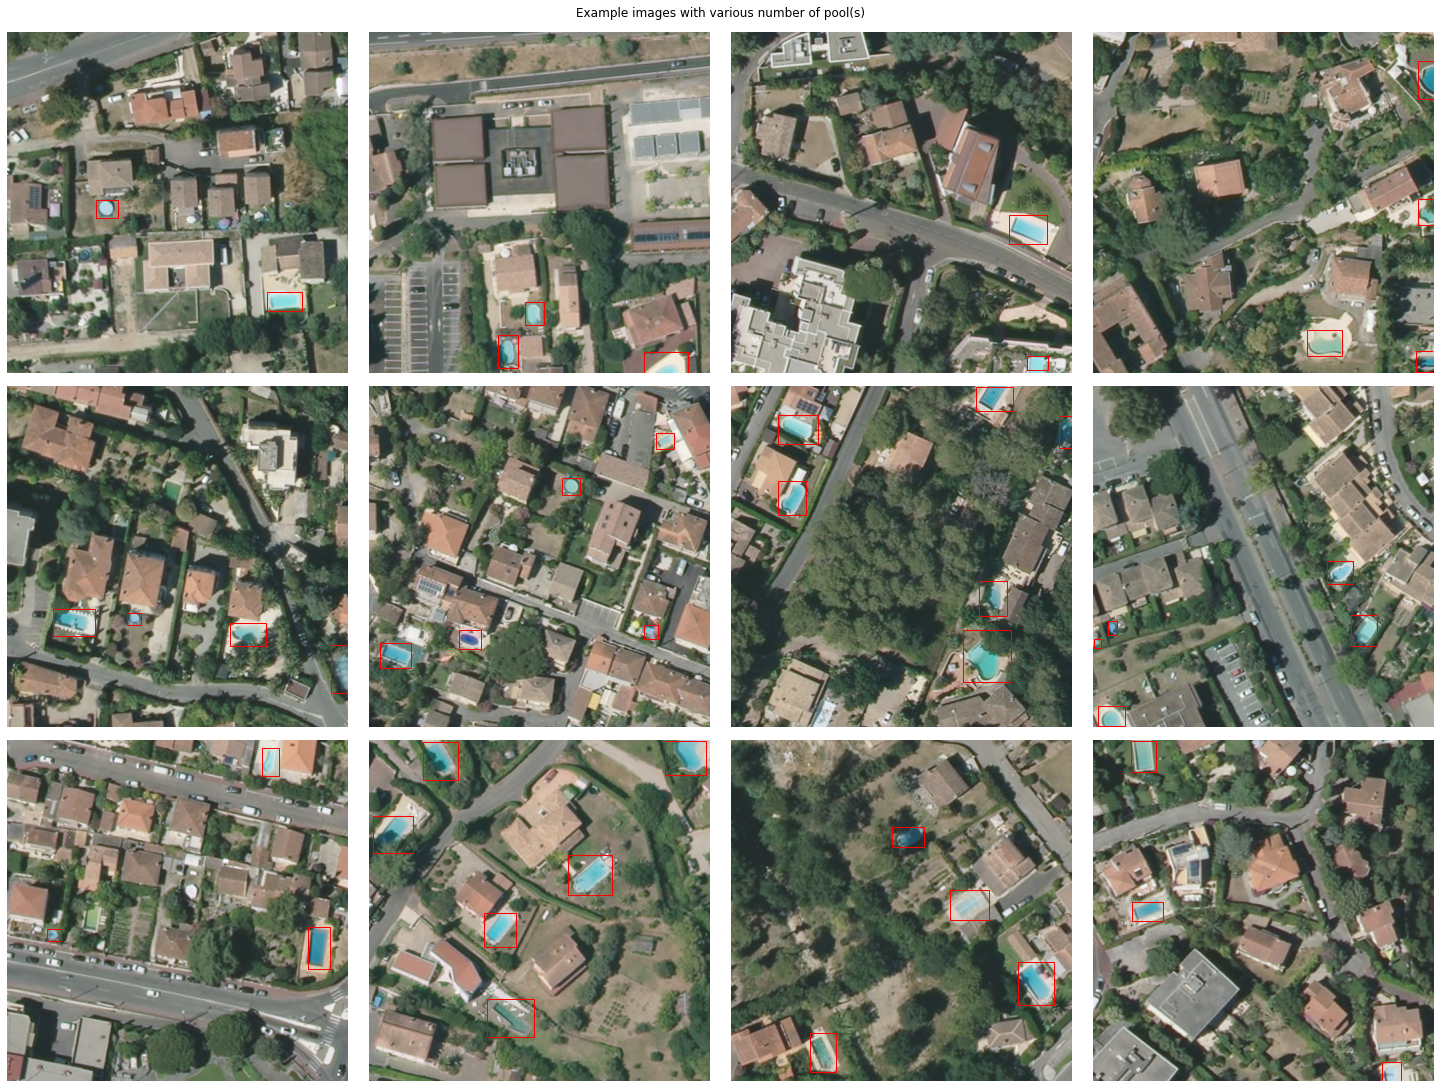

In [ ]:
plot_image_examples(df, title='Example images with various number of pool(s)')

## Swimming Pools Location Heatmap

In [ ]:
def show_heatmap_of_image(df, filename):
  heatmap = np.zeros(shape=(512, 512))
  bbox = get_all_bboxes(df, filename)
  bbox_np = np.array(bbox)

  for row in bbox_np:
    heatmap[row[1]:row[3]+1, row[0]:row[2]+1] += 1
  fig = plt.figure(figsize=(10,12))
  plt.imshow(heatmap, cmap="bone")
  plt.title(f"Location of Swimming Pool(s)", fontweight="bold")
  plt.show()

  img = Image.open(TRAIN_DIR + filename)
  plt.figure(figsize=(10,12))
  plt.imshow(img)

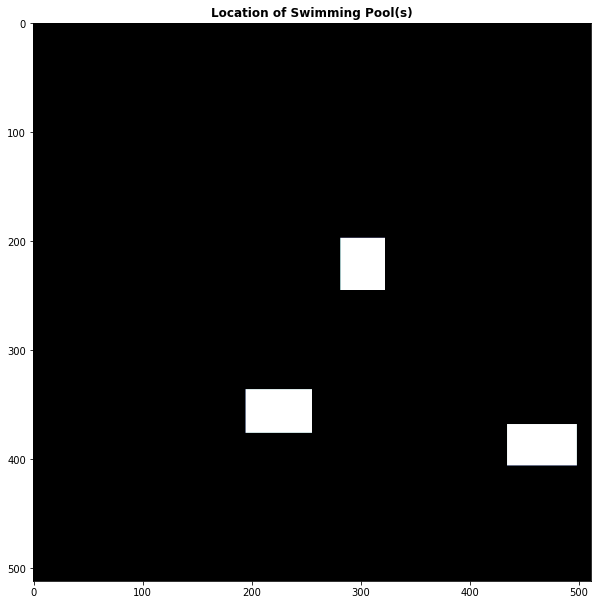

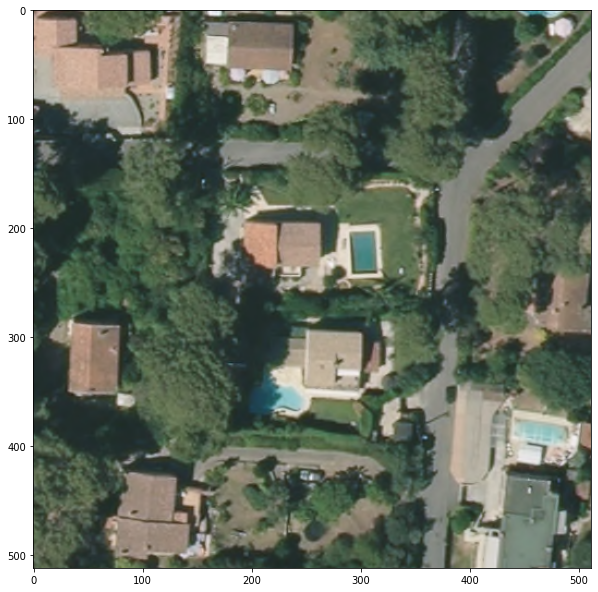

In [ ]:
show_heatmap_of_image(df,"CANNES_TILES_512x512.1042.png")

## Swimming Pools Size Distribution (in meter$^2$) \
The resolution of this image is 20 cm per pixel

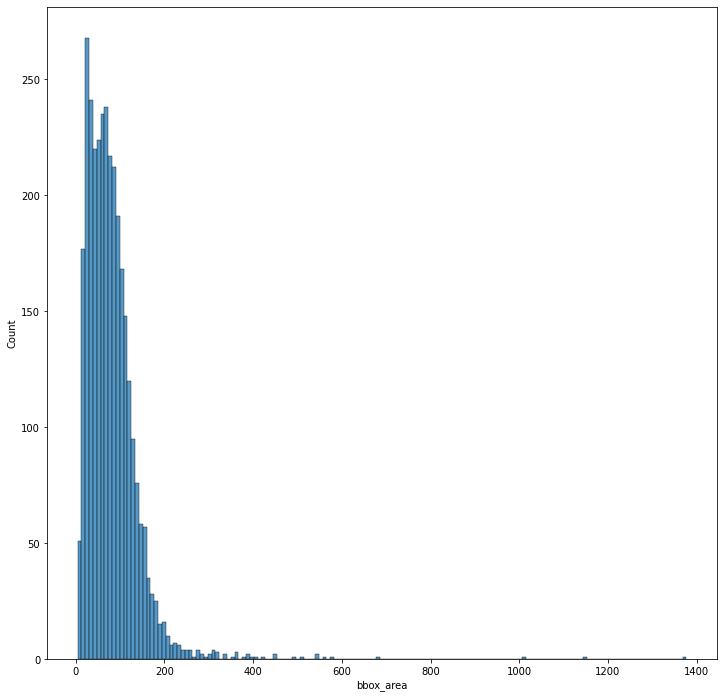

In [ ]:
panjang = (df['xmax'] - df['xmin'])*0.2
lebar = (df['ymax'] - df['ymin'])*0.2
df['bbox_area'] = panjang*lebar
plt.figure(figsize=(12,12))
sns.histplot(data=df['bbox_area'])

## Number of Swimming Pool(s) per Image

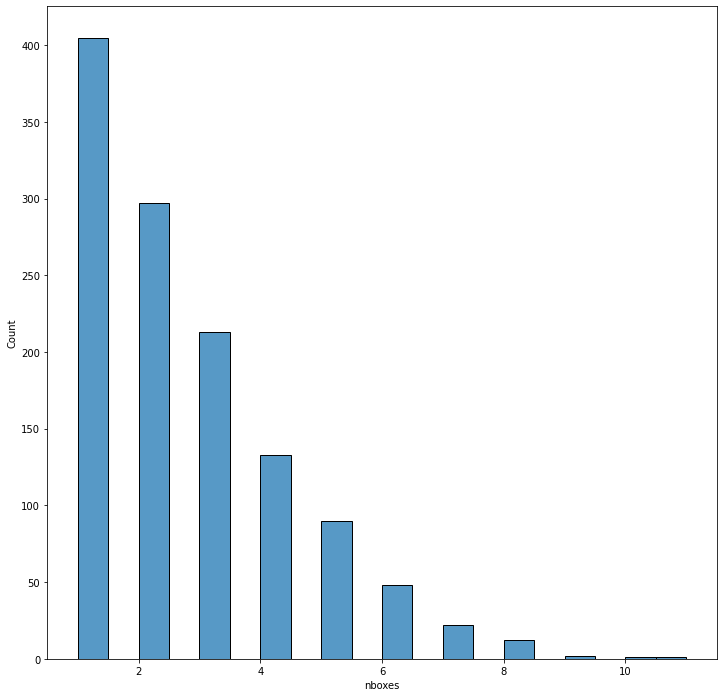

In [ ]:
# compute the number of bounding boxes per train image
df['nboxes'] = df.apply(lambda row: 1 if np.isfinite(row.xmin) else 0, axis=1)
train_images_count = df.groupby('image_id').sum().reset_index()
plt.figure(figsize=(12,12))
sns.histplot(data=train_images_count['nboxes'], bins=20)

In [ ]:
df.to_csv('EDA.csv',index=False)